# Introduction

In this colab, we will go through using pre-trained embeddings for classifying a given piece of text into one of 14 classes for the [DBPedia](https://huggingface.co/datasets/dbpedia_14) task.

# Some helper methods related to Colabs, feel free to ignore.

In [177]:
!mkdir fonts/

# Download the fonts we need.
!wget -qO Noto_Sans.zip https://drive.google.com/uc?id=1-0tqK8qCFRVqsRZag4YYJmy2ZnPOD5VD&export=download 
!unzip -qo Noto_Sans.zip -d fonts/Noto_Sans
!wget -qO Roboto.zip https://drive.google.com/uc?id=1Xo2EUtHc5CIAo3l5V1FbtRopbV7_u-Cu&export=download
!unzip -qo Roboto.zip -d fonts/Roboto
!wget -qO Poppins.zip https://drive.google.com/uc?id=18Flk0fW_8RBNmKyDJEnMA43GjFjxp-i0&export=download
!unzip -qo Poppins.zip -d fonts/Poppins

!rm Noto_Sans.zip Roboto.zip Poppins.zip

mkdir: cannot create directory ‘fonts/’: File exists


In [178]:
!pip install -q git+https://github.com/EfficientDL/codelab_utils.git

In [179]:
import matplotlib.pyplot as plt
import codelab_utils.mpl_styles as mpl_styles

mpl_styles.set_default_styles()
plt.rcParams['font.family'] = 'Poppins'

# Downloading and preparing the dataset

In [180]:
!wget https://s3.amazonaws.com/fast-ai-nlp/dbpedia_csv.tgz
!tar -xvf dbpedia_csv.tgz

--2022-03-13 09:40:59--  https://s3.amazonaws.com/fast-ai-nlp/dbpedia_csv.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.42.46
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.42.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68341743 (65M) [application/x-tar]
Saving to: ‘dbpedia_csv.tgz.4’

dbpedia_csv.tgz.4   100%[===================>]  65.17M  33.6MB/s    in 1.9s    

2022-03-13 09:41:01 (33.6 MB/s) - ‘dbpedia_csv.tgz.4’ saved [68341743/68341743]

dbpedia_csv/
dbpedia_csv/train.csv
dbpedia_csv/readme.txt
dbpedia_csv/test.csv
dbpedia_csv/classes.txt


## Let's explore the dataset.

First, let's see what classes do we have.

In [181]:
import os
import pprint

class_names = open(os.path.join('dbpedia_csv', 'classes.txt')).read().splitlines()
num_classes = len(class_names)

# The classes are as follows.
pprint.pprint(class_names)

['Company',
 'EducationalInstitution',
 'Artist',
 'Athlete',
 'OfficeHolder',
 'MeanOfTransportation',
 'Building',
 'NaturalPlace',
 'Village',
 'Animal',
 'Plant',
 'Album',
 'Film',
 'WrittenWork']


### Now, let's take a look at a sample of the training / test data itself.

The data is in CSV format, and has the following schema:
```
<class-id/>,"<title/>","<description/>"
```

The class id is 1-indexed.

In [182]:
!shuf -n 20 dbpedia_csv/train.csv

11,"Pauridia"," Pauridia is a flowering plant genus in the family Hypoxidaceae endemic to South Africa. Two species are recognised:Pauridia longituba M.F.Thomps.Pauridia minuta (L.f.) T.Durand & Schinz↑ ↑"
12,"Vertigo 2005: Live from Chicago"," Vertigo 2005: Live from Chicago (sometimes titled Vertigo '05: Live from Chicago) is a concert film by Irish rock band U2 showcasing two concerts recorded in Chicago Illinois during band's 2005 Vertigo Tour. The film was released as a DVD later in the year (see 2005 in music) on 14 November by Island Records in most parts of the world and was released in the United States a day later by Interscope Records."
3,"Michael Burks"," Michael Burks (July 30 1957 – May 6 2012) was an American electric blues and soul blues guitarist singer and songwriter. He is best known for his tracks I Smell Smoke and Hard Come Easy Go and variously worked with Johnnie Taylor O. V. Wright and Marquise Knox. He was the son of the bassist Frederick Burks.The Allmusic jou

In [183]:
# Let's find the number of train and test examples.
!wc -l dbpedia_csv/train.csv
!wc -l dbpedia_csv/test.csv

560000 dbpedia_csv/train.csv
70000 dbpedia_csv/test.csv


## Converting the data into NumPy format.

In [184]:
import numpy as np
import os
import pandas as pd
import random

def process_csv(file_path, num_samples=10**9):
  df = pd.read_csv(file_path, header=None, usecols=[0, 2]).sample(frac=1)
  input_texts = df[2].to_numpy()
  # Original labels are 1-indexed
  labels = df[0].to_numpy() - 1
  return input_texts[:num_samples], labels[:num_samples] 

# Let's only use a small number of training samples in this exercise.
num_train_samples = 20000
x_train, y_train = process_csv(os.path.join('dbpedia_csv', 'train.csv'), 
                               num_samples=num_train_samples)
x_test, y_test = process_csv(os.path.join('dbpedia_csv', 'test.csv'))

print('Training data shapes: {}, {}'.format(x_train.shape, y_train.shape))
print('Test data shapes: {}, {}'.format(x_test.shape, y_test.shape))

Training data shapes: (20000,), (20000,)
Test data shapes: (70000,), (70000,)


# Create the vocabulary.

We will use Keras' `TextVectorization` layers, which helps you find the top N words in your dataset, sort them in order of frequency, and assign an index to them. We will use this vocabulary to later convert our free-form strings to a list of indices.

In this case, we will keep the top 5K words, and will ensure that each text string is exactly 250 tokens in size. This might mean padding for text strings that are smaller, and truncating for the ones which are longer than 250 tokens.

Note that we are doing vectorization only on the train dataset, because we don't want to peek into the test dataset.

In [185]:
import tensorflow as tf

# Size of our vocabulary.
vocab_size = 5000

# This controls the max number of tokens the layer with tokenize, by truncating
# the rest of the sequence.
max_seq_len = 100

vectorization_layer = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size, 
    output_sequence_length=max_seq_len)

# This step allows the vectorization layer to build the vocabulary.
train_text_ds = tf.data.Dataset.from_tensor_slices(x_train).batch(512)
vectorization_layer.adapt(train_text_ds)

It's possiible to see what the top words in our vocabulary are. Simply run the `vectorization_layer.get_vocabulary()` method. In our case, let's see the top 10 words.

Notice that the first two elements are '' (reserved token for padding), and 'UNK' (reserved for tokens which are absent from the vocabulary). Then we see the usual stop words like 'the', 'in', 'of', and so on. 

In [186]:
vocabulary = vectorization_layer.get_vocabulary()
vocabulary[:10]

['', '[UNK]', 'the', 'in', 'of', 'is', 'a', 'and', 'was', 'by']

Since it is a regular layer, we can also invoke it in Keras.

Let's try to vectorize a given string. We will add a random token at the end that we are confident will not be in the vocabulary.

In [187]:
edl_sequence_output = vectorization_layer(
    [['efficient deep learning x123!']]).numpy()[0, :4]
edl_sequence_output

array([   1, 1383, 1783,    1])

Now let's look up the indices in the vocabulary to make sure that it works well.

If you notice the random token (x123!) was converted back to [UNK], since we didn't have it in the vocabulary during the vectorization. Additionally the word 'efficient' was also not found in the vocabulary, because it was not in the top 5K words by frequency. 

In a way, this process of building the vocabulary helps us keep some of the more meaningful tokens in the given input.

In [188]:
' '.join(np.take(vocabulary, edl_sequence_output))

'[UNK] deep learning [UNK]'

## Vectorize the train and test data.

We now need to convert the train and test data into integer sequences.

In [189]:
x_train_vectorized = vectorization_layer(x_train).numpy()
x_test_vectorized = vectorization_layer(x_test).numpy()

# Creating the embedding matrix.

We will now create the embedding matrix using pre-trained Word2Vec embeddings from [TFHub](https://tfhub.dev). We will use the existing Word2Vec checkpoint there ([Link](https://tfhub.dev/google/Wiki-words-250/2)).

In [190]:
import tensorflow_hub as tfhub

word2vec_hub_layer = tfhub.KerasLayer(
    'https://tfhub.dev/google/Wiki-words-250/2')
word2vec_embeddings = word2vec_hub_layer(vocabulary)

embedding_dim = 250

# The shape of the word2vec_embeddings would be (vocabulary_size, 250),
# since we are embedding each row in the vocabulary and the size of the
# word2vec embeddings is 250 dimensions.
print('Vocabulary Size:', len(vocabulary))
print('word2vec_embeddings.shape:', word2vec_embeddings.shape)

# Verify that this is true.
tf.assert_equal(word2vec_embeddings.shape, (len(vocabulary), embedding_dim))

Vocabulary Size: 5000
word2vec_embeddings.shape: (5000, 250)


## Creating the embedding layer.

We can now create a method which returns an embedding layer initialized directly from the `word2vec_embeddings` tensor as the initializer.

We will also create a method that returns a layer initialized with random embeddings.

In [191]:
def get_pretrained_embedding_layer(
    trainable=False,
    embedding_dim_size=embedding_dim,
    embedding_tensor=word2vec_embeddings):
  return tf.keras.layers.Embedding(
      vocab_size,
      embedding_dim_size,
      embeddings_initializer=tf.keras.initializers.Constant(
          word2vec_embeddings),
      trainable=trainable,
  )

In [192]:
def get_untrained_embedding_layer(trainable=True, embedding_dim=250):
  return tf.keras.layers.Embedding(
      vocab_size,
      embedding_dim,
      trainable=trainable,
  )

# Training the models.

Now the fun part! We will now start training the models.

## A simple Bag-of-Words model.

Let's create a simple Bag-of-Words (BOW) model, that averages the embeddings for a given input, and then passes it through a few dense layers, before generating an output tensor over `num_classes` number of classes.

In [193]:
from tensorflow.keras import layers

def get_bow_model(embedding_layer):
  int_sequences_input = tf.keras.Input(shape=(None,), dtype='int64')
  embedded_sequences = embedding_layer(int_sequences_input)

  x = tf.reduce_mean(embedded_sequences, axis=1)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
  
  output = x
  model = tf.keras.Model(int_sequences_input, output, name='bow')
  model.summary()
  return model

In [205]:
# Train a model with pre-trained Word2Vec embeddings.
bow_model_w2v = get_bow_model(get_pretrained_embedding_layer(trainable=True))
bow_model_w2v.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer='adam', 
    metrics=["accuracy"]
)

bow_model_w2v_history = bow_model_w2v.fit(
    x_train_vectorized, y_train, batch_size=128, epochs=20,
    validation_data=(x_test_vectorized, y_test))

Model: "bow"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_55 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_45 (Embedding)    (None, None, 250)         1250000   
                                                                 
 tf.math.reduce_mean_17 (TFO  (None, 250)              0         
 pLambda)                                                        
                                                                 
 dense_96 (Dense)            (None, 512)               128512    
                                                                 
 dense_97 (Dense)            (None, 128)               65664     
                                                                 
 dense_98 (Dense)            (None, 14)                1806      
                                                               

In [195]:
# Train a model without pre-trained embeddings.
bow_model_no_w2v = get_bow_model(get_untrained_embedding_layer())
bow_model_no_w2v.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer='adam', 
    metrics=["accuracy"]
)

bow_model_no_w2v_history = bow_model_no_w2v.fit(
    x_train_vectorized, y_train, batch_size=128, epochs=20,
    validation_data=(x_test_vectorized, y_test))

Model: "bow"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_49 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_41 (Embedding)    (None, None, 250)         1250000   
                                                                 
 tf.math.reduce_mean_16 (TFO  (None, 250)              0         
 pLambda)                                                        
                                                                 
 dense_87 (Dense)            (None, 512)               128512    
                                                                 
 dense_88 (Dense)            (None, 128)               65664     
                                                                 
 dense_89 (Dense)            (None, 14)                1806      
                                                               

### Comparing between using / not-using pre-trained embeddings.

As you can see the model with pre-trained embeddings reaches a higher accuracy, and is consistently better.

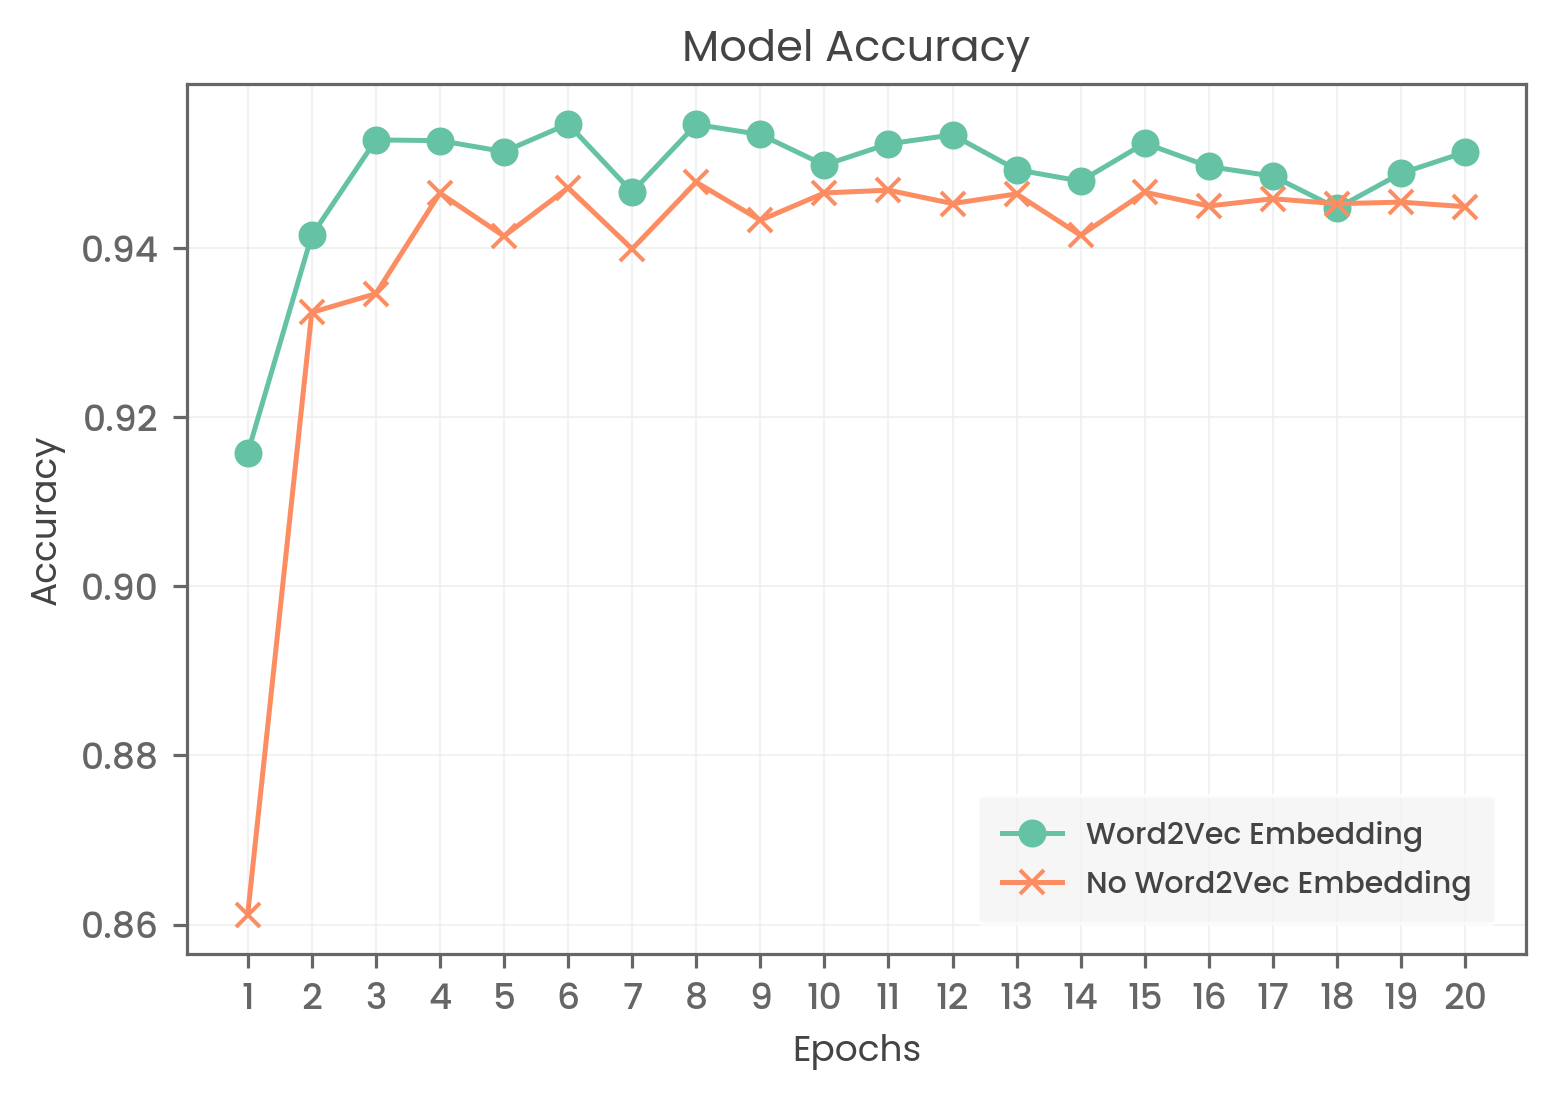

In [206]:
import matplotlib.pyplot as plt

# Plot the model accuracy over the epochs.
val_accuracy_key = 'val_accuracy'
num_epochs = len(bow_model_w2v_history.history[val_accuracy_key])
plt.plot(range(1, num_epochs + 1), 
         bow_model_w2v_history.history[val_accuracy_key], '-o')
plt.plot(range(1, num_epochs + 1), 
         bow_model_no_w2v_history.history[val_accuracy_key], '-x')

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.xticks(range(1, num_epochs + 1))
plt.legend(['Word2Vec Embedding', 'No Word2Vec Embedding'], loc='lower right')
plt.show()

## Using a more complex CNN model.
Let's create a slightly more complex model that can hopefully capture more information from the embedding sequences, instead of just averaging them in the BOW model.

In [197]:
from tensorflow.keras import layers

def get_cnn_model(embedding_layer):
  int_sequences_input = tf.keras.Input(shape=(None,), dtype="int64")
  embedded_sequences = embedding_layer(int_sequences_input)

  # Run a convolutional layer on top of the sequences, and use pooling to
  # reduce the sequence length.  
  x = layers.Conv1D(128, 5, activation="relu")(embedded_sequences)
  x = layers.MaxPooling1D(3)(x)
  x = layers.Conv1D(128, 5, activation="relu")(x)
  x = layers.MaxPooling1D(3)(x)
  x = layers.Conv1D(128, 5, activation="relu")(x)

  # Global average pooling averages out the entire sequence.
  x = layers.GlobalMaxPooling1D()(x)
  x = layers.Dense(128, activation="relu")(x)
  x = layers.Dropout(0.5)(x)
  preds = layers.Dense(14, activation="softmax")(x)
  model = tf.keras.Model(int_sequences_input, preds)
  
  model.summary()
  return model

In [203]:
# Training with pre-trained Word2Vec embeddings.
cnn_model_w2v = get_cnn_model(get_pretrained_embedding_layer(trainable=True))
cnn_model_w2v.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer='adam', 
    metrics=["accuracy"]
)

cnn_model_w2v_history = cnn_model_w2v.fit(
    x_train_vectorized, y_train, batch_size=128, epochs=10,
    validation_data=(x_test_vectorized, y_test))

Model: "model_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_54 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_44 (Embedding)    (None, None, 250)         1250000   
                                                                 
 conv1d_84 (Conv1D)          (None, None, 128)         160128    
                                                                 
 max_pooling1d_56 (MaxPoolin  (None, None, 128)        0         
 g1D)                                                            
                                                                 
 conv1d_85 (Conv1D)          (None, None, 128)         82048     
                                                                 
 max_pooling1d_57 (MaxPoolin  (None, None, 128)        0         
 g1D)                                                     

In [199]:
# Training without pre-trained embeddings.
cnn_model_no_w2v = get_cnn_model(get_untrained_embedding_layer())
cnn_model_no_w2v.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer='adam', 
    metrics=["accuracy"]
)

cnn_model_no_w2v_history = cnn_model_no_w2v.fit(
    x_train_vectorized, y_train, batch_size=128, epochs=10,
    validation_data=(x_test_vectorized, y_test))

Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_51 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_43 (Embedding)    (None, None, 250)         1250000   
                                                                 
 conv1d_81 (Conv1D)          (None, None, 128)         160128    
                                                                 
 max_pooling1d_54 (MaxPoolin  (None, None, 128)        0         
 g1D)                                                            
                                                                 
 conv1d_82 (Conv1D)          (None, None, 128)         82048     
                                                                 
 max_pooling1d_55 (MaxPoolin  (None, None, 128)        0         
 g1D)                                                     

### Comparing between using / not-using pre-trained embeddings.

As you can see in this example as well, the model with pre-trained embeddings reaches a higher accuracy and is consistently better.

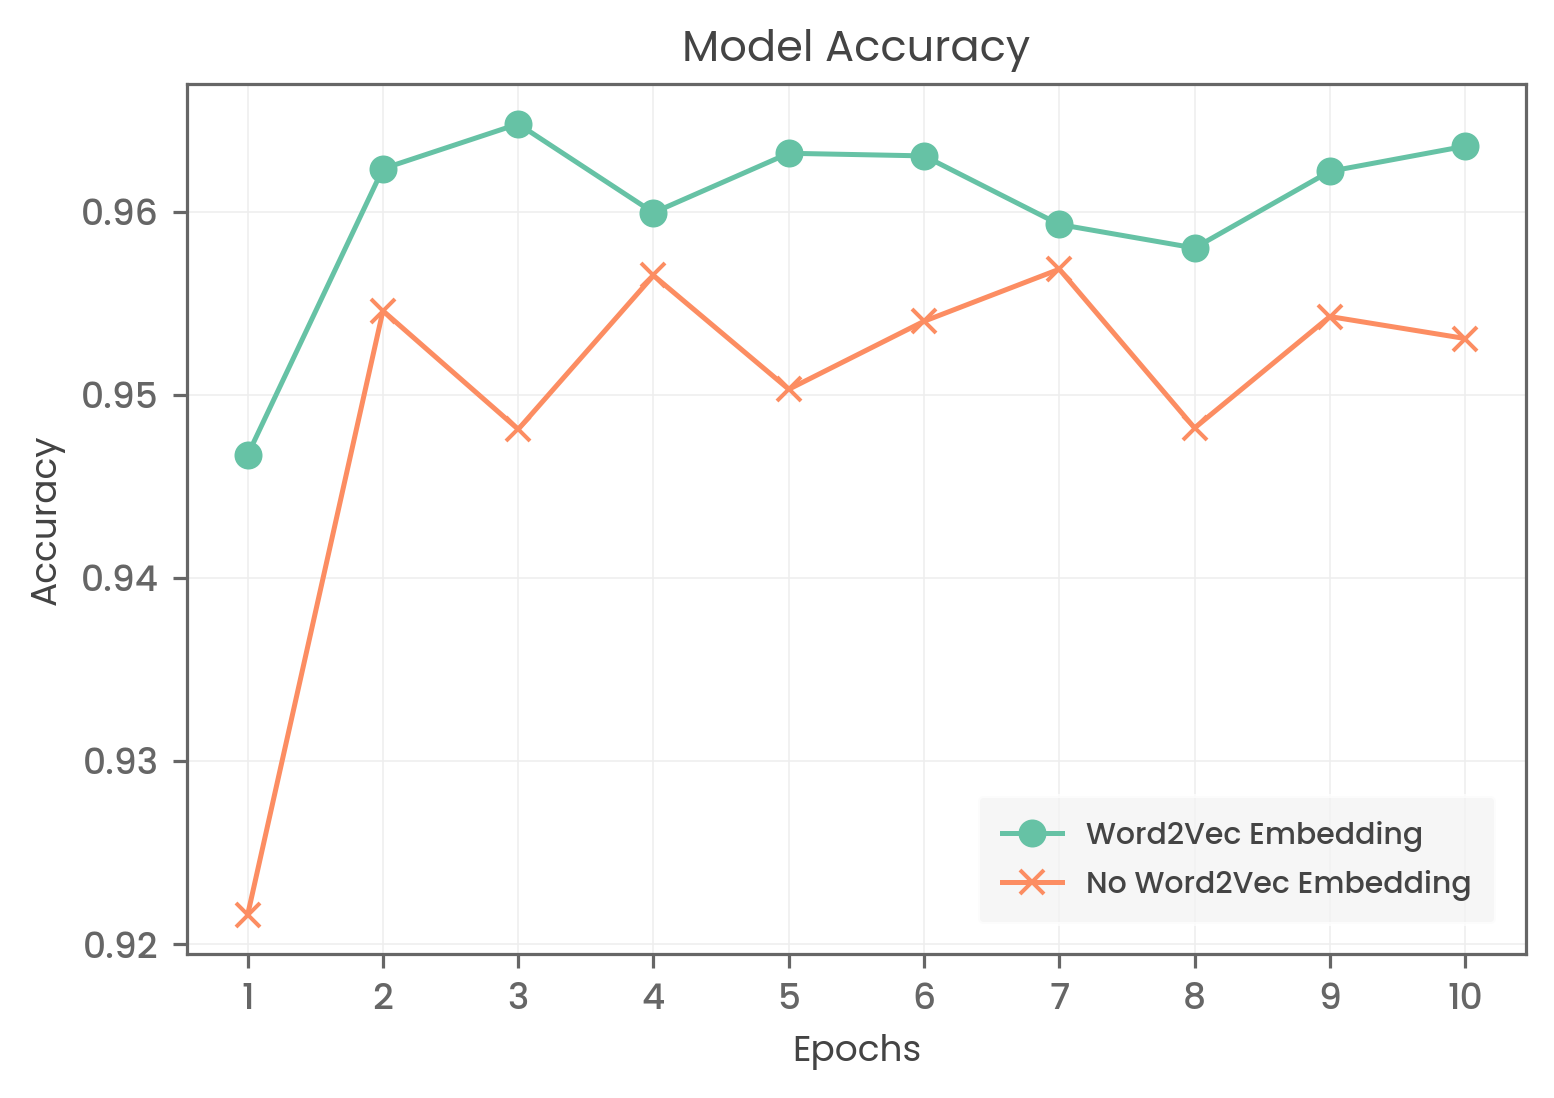

In [204]:
# Plot the model accuracy over the epochs.
val_accuracy_key = 'val_accuracy'
num_epochs = len(cnn_model_w2v_history.history[val_accuracy_key])
plt.plot(range(1, num_epochs + 1), 
         cnn_model_w2v_history.history[val_accuracy_key], '-o')
plt.plot(range(1, num_epochs + 1), 
         cnn_model_no_w2v_history.history[val_accuracy_key], '-x')

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.xticks(range(1, num_epochs + 1))
plt.legend(['Word2Vec Embedding', 'No Word2Vec Embedding'], loc='lower right')
plt.show()

# Exporting an end-to-end model.

To use the model in production, we would ideally want it to take the input as a string, instead of sequence of integers. It is possible to stitch the vectorization layer as the input of the model.

In [202]:
string_input = tf.keras.Input(shape=(1,), dtype='string')
x = vectorization_layer(string_input)
predictions = cnn_model_w2v(x)
end_to_end_model = tf.keras.Model(string_input, predictions)

probabilities = end_to_end_model.predict(
    [['Usain Bolt is a very well known sprinter and Olympic medal winner.']]
)

class_names[np.argmax(probabilities[0])]

'Athlete'